In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import pandas as pd

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()

In [6]:
train_set=pd.read_pickle('/content/integrators_next_state_train.pickle')
test_set=pd.read_pickle('/content/integrators_next_state_test.pickle')

In [7]:
train_set=[trace.to(device) for trace in train_set]
test_set=[trace.to(device) for trace in test_set]

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.fc = nn.Linear(output_size, output_size)
        self.sigmoid=nn.Sigmoid()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden))
        hidden = self.sigmoid(self.i2h(combined))
        output = self.sigmoid(self.h2o(hidden))
        output = self.sigmoid(self.fc(output))
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.hidden_size).to(device)

In [64]:
n_iters = 100
print_every = 5
learning_rate = 0.00005 # If you set this too high, it might explode. If too low, it might not learn
#loss_function = nn.MSELoss()
loss_function = CustomLoss()
regression_loss_function=nn.MSELoss()
classification_loss_function=nn.BCELoss()
n_hidden = 10
dimension=train_set[0][0].size(0)
rnn = RNN(dimension,n_hidden,dimension)
rnn.to(device)
optimizer=optim.SGD(rnn.parameters(),learning_rate)

In [65]:
losses=[]
losses_regression=[]
losses_classification=[]

count=0
for iter in range(1, n_iters + 1):
    for trace in train_set:
        hidden=rnn.initHidden()
        for i in range(len(trace)-1):
            #print(hidden)
            output, hidden=rnn(trace[i],hidden)


            hidden=hidden.clone().detach()
            #loss=loss_function(output,trace[i+1])

            regression_output=torch.cat((output[0:3],output[-1].reshape(1)))
            regression_correct=torch.cat((trace[i+1][0:3],trace[i+1][-1].reshape(1)))

            classification_output=output[3:11]
            classification_correct=trace[i+1][3:11]

            loss_regression=regression_loss_function(regression_output,regression_correct)
            loss_classification=regression_loss_function(classification_output,classification_correct)

            loss=loss_regression+loss_classification

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            losses.append(loss)
            losses_regression.append(loss_regression)
            losses_classification.append(loss_classification)
    if count % print_every == 0:
        print(f"total losses are between {min(losses[-5:])} and {max(losses[-5:])}")
        print(f"regression losses are between {min(losses_regression[-5:])} and {max(losses_regression[-5:])}")
        print(f"regression classification are between {min(losses_classification[-5:])} and {max(losses_classification[-5:])}")
        print(" ")
    count+=1

total losses are between 0.29455727338790894 and 0.3545948565006256
regression losses are between 0.04676438122987747 and 0.0929652526974678
regression classification are between 0.21537736058235168 and 0.27252501249313354
 
total losses are between 0.25752758979797363 and 0.31330710649490356
regression losses are between 0.03316115587949753 and 0.07101839780807495
regression classification are between 0.19864535331726074 and 0.252434104681015
 
total losses are between 0.23037511110305786 and 0.2823967933654785
regression losses are between 0.02440202794969082 and 0.05571596324443817
regression classification are between 0.18546780943870544 and 0.23539236187934875
 
total losses are between 0.21047979593276978 and 0.2584892213344574
regression losses are between 0.018682003021240234 and 0.04485362023115158
regression classification are between 0.17535343766212463 and 0.2212185263633728
 
total losses are between 0.19590039551258087 and 0.2399095594882965
regression losses are between 

In [81]:
a=[1,2,3,4,5]
a[-2:]

[4, 5]

In [80]:
min(losses[-100:])

tensor(0.0458, device='cuda:0', grad_fn=<AddBackward0>)

In [79]:
min(losses[-5:])

tensor(0.1603, device='cuda:0', grad_fn=<AddBackward0>)

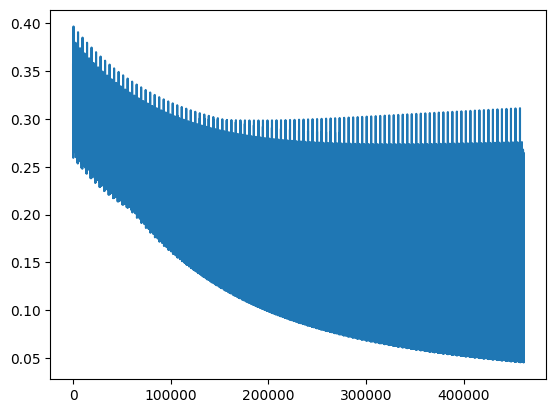

In [66]:
plt.plot(range(len(losses)),[loss.detach().cpu().numpy() for loss in losses])


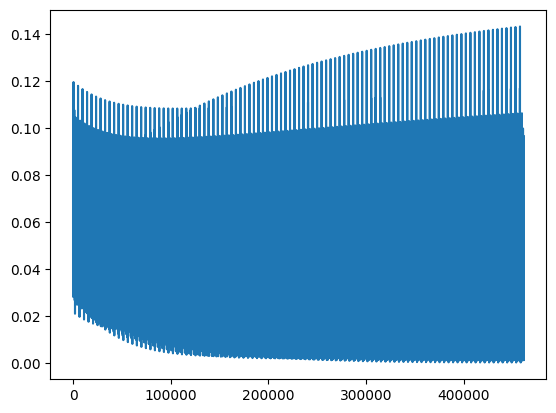

In [70]:
plt.plot(range(len(losses_regression)),[loss.detach().cpu().numpy() for loss in losses_regression])


In [73]:
losses[0]

tensor(0.3568, device='cuda:0', grad_fn=<AddBackward0>)

In [76]:
losses[0].detach().cpu().numpy().item()

0.3567594885826111

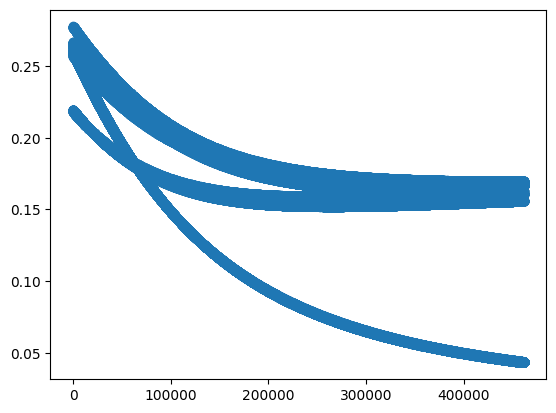

In [77]:
plt.scatter(range(len(losses)),[loss.detach().cpu().numpy().item() for loss in losses_classification])


In [28]:
def evaluate(nn,trace):
    losses=[]
    hidden = rnn.initHidden()
    for i in range(len(trace)-1):
        output,hidden=nn(trace[i],hidden)
        losses.append(loss_function(output,trace[i+1]).item())
        #print(f"tryingt to predict {trace[i+1]}")
        #print(f"predicted {output}")
        #    print(" ")
    return losses


In [29]:
evaluate(rnn,test_set[5])

tryingt to predict tensor([0.8334, 0.9253, 0.5150, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.4956], device='cuda:0')
predicted tensor([0.5250, 0.4934, 0.5809, 0.4115, 0.4415, 0.5512, 0.5109, 0.5843, 0.6301,
        0.4694, 0.3946, 0.5397], device='cuda:0', grad_fn=<SigmoidBackward0>)
 
tryingt to predict tensor([0.6088, 0.9253, 0.5150, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0563], device='cuda:0')
predicted tensor([0.5245, 0.4931, 0.5807, 0.4129, 0.4414, 0.5507, 0.5105, 0.5836, 0.6297,
        0.4697, 0.3949, 0.5407], device='cuda:0', grad_fn=<SigmoidBackward0>)
 
tryingt to predict tensor([0.6088, 0.9253, 0.4717, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0281], device='cuda:0')
predicted tensor([0.5239, 0.4941, 0.5805, 0.4131, 0.4417, 0.5509, 0.5110, 0.5842, 0.6297,
        0.4705, 0.3944, 0.5402], device='cuda:0', grad_fn=<SigmoidBackward0>)
 
tryingt to predict tensor([0.6088, 0.9253, 

[0.20403961837291718,
 0.1847011297941208,
 0.18773488700389862,
 0.18910348415374756,
 0.18987946212291718,
 0.1903865784406662,
 0.1907482147216797,
 0.19102126359939575,
 0.19123613834381104,
 0.1914106011390686,
 0.2310633659362793]

0.06196266186658208


(array([83.,  7.,  4.,  3.,  1.,  3.,  6.,  7., 11.,  6.]),
 array([0.02777645, 0.0410588 , 0.05434116, 0.06762351, 0.08090587,
        0.09418823, 0.10747058, 0.12075294, 0.13403529, 0.14731765,
        0.16060001]),
 <BarContainer object of 10 artists>)

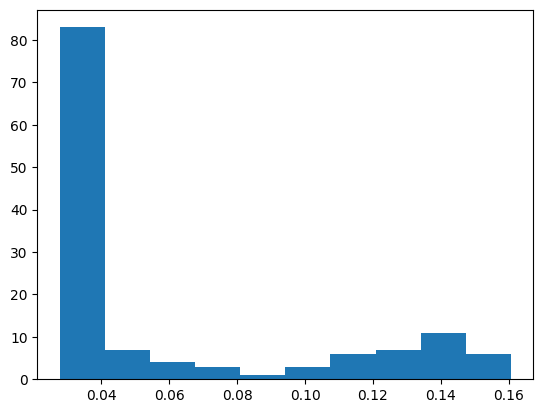

In [11]:
losses=[]
for trace in test_set:
    losses.extend(evaluate(rnn,trace))
    #print(losses)
print(np.mean(losses))
plt.hist(losses)

In [13]:
print(test_set[5])
hidden=rnn.initHidden()
rnn(test_set[5][0],hidden)

tensor([[0.8334, 0.9253, 0.6879, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.2250],
        [0.8334, 0.9253, 0.5150, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.4956],
        [0.6088, 0.9253, 0.5150, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0563],
        [0.6088, 0.9253, 0.4717, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0281],
        [0.6088, 0.9253, 0.4501, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0176],
        [0.6088, 0.9253, 0.4366, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0123],
        [0.6088, 0.9253, 0.4271, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0092],
        [0.6088, 0.9253, 0.4200, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0073],
        [0.6088, 0.9253, 0.4145, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,

(tensor([ 0.2664,  0.6558,  0.3472,  0.2856,  0.0257,  0.0760, -0.0689,  0.0726,
          0.4490,  0.0738, -0.1794,  0.0750], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([ 0.1157, -0.1700,  0.2668,  0.0674,  0.1884, -0.3713,  0.3740, -0.1209,
         -0.3581, -0.4019], device='cuda:0', grad_fn=<ViewBackward0>))

In [14]:
def squared_error(input,target):
  return torch.pow(input-target,2)

In [21]:
class CustomLoss(nn.Module):
  def __init__(self):
        super(CustomLoss, self).__init__()

  def forward(self,input,target):
    mse=(1/4)*(squared_error(input[0],target[0])+squared_error(input[1],target[1])+squared_error(input[2],target[2])+squared_error(input[-1],target[-1]))
    l=torch.zeros(8)
    for i in range(len(l)):
      l[i]=-(target[i]*torch.log(input[i])+(1-target[i])*torch.log(1-input[i]))
    bce=torch.mean(l)
    return 0.5*mse+bce

In [12]:
l=torch.zeros(3)
l[1]=2
l

tensor([0., 2., 0.])

In [8]:
train_set[0]

tensor([[0.6102, 0.8874, 0.1609, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.1765],
        [0.5267, 0.8874, 0.1609, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000]], device='cuda:0')